# 1D Three Phase Simulation of Alloys and PINN model development 


This notebook contains the simulation of 1D Phase change of aluminium alloy. There will be three phases (solid,liquid and mushy).   

The approach used is finite difference method and the physics involved in heat conduction.

Import Libraries

In [35]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools

from ht_sim_2 import sim1d


from pyDOE2 import fullfact
from pyDOE2 import fracfact

import statsmodels.api as sm

from statsmodels.formula.api import ols
from scipy.stats import ttest_ind



### <center>Pareto analysis</center>

<p style="font-size:12px; font-family:'Times New Roman', sans-serif; line-height:1.6;">

In this section sensitivity study of the soldification is performed with respect to different material properties and  initial/boundary conditions. The soldification time is the variable under study and it is calcualted based on solution of 1D heat transfer and phase change equation.



Here the parameters/factors are as follows:-

1. Density for material in liquid state $\rho_l$.<br>
2. Density for material in solid state $\rho_s$.<br>
3. Latent Heat of Fusion <br>
4. Specific heat of material in liquid state $C_{pl}$ <br>
5. Specific heat of material in solid state $C_{ps}$ <br>
6. Thermal Conductivity of material in liquid state $k_l$<br>
7. Thermal Conductivity of material in solid state $k_s$ <br>


Boundary conditions:-
8. Surrounding Temperature <br>

Initial Conditions:-

9. Initial_temperature <br>


</p>




A full factorial DOE table is generated to study solidifcation time with the different factors and their corresponding levels.

In [36]:
# Create a full factorial design

num_levels = 2 
levels = [0, 1]
num_vars = 9
design = fullfact([num_levels]*num_vars)

# Create a DataFrame from the full factorial design

doe_df_sol_time = pd.DataFrame(design, columns=[f'Var_{i}' for i in range(1, num_vars+1)])
print(doe_df_sol_time.shape)

(512, 9)


The number of runs are large so a fractional factorial design is adopted.

In [37]:
#Create a fractional factorial design

from pyDOE2 import fracfact

num_levels = 2
levels = [0, 1]
num_vars = 9
design2 = fracfact('a b c d e  abcde abcd bcde adce ')
L_level = 0.99
R_level = 1.01
factor_levels = {
    'rho_l': [2760.0, 2761.0],
    'rho_s': [3000.0, 3001.0],
    'k_l': [96.0, 120.0],
    'k_s': [110.0, 130.0],
    'cp_l': [927.0, 947.0],
    'cp_s': [967.0, 987.0],
    'Surr_temp': [313.0, 323.0],
    'L_fusion': [389e3, 400e3 ],
    'temp_init': [880.0, 890.0],

}

factor_names = list(factor_levels.keys())

# Create a DataFrame from the fractional factorial design
doe_df_sol_time_fracfact = pd.DataFrame(design2, columns=factor_names)

for factor, levels in factor_levels.items():
    doe_df_sol_time_fracfact[factor] = doe_df_sol_time_fracfact[factor].map({-1: levels[0], 1: levels[1]})

    
print(doe_df_sol_time_fracfact.shape)

(32, 9)


In [38]:
Res_doe_sol_time = doe_df_sol_time_fracfact.copy()

Res_doe_sol_time['total_sol_time'] = [0.0] * Res_doe_sol_time.shape[0] # Data frame inclduing the response variable

print(Res_doe_sol_time.head(5))



    rho_l   rho_s    k_l    k_s   cp_l   cp_s  Surr_temp  L_fusion  temp_init  \
0  2760.0  3000.0   96.0  110.0  927.0  967.0      323.0  400000.0      890.0   
1  2761.0  3000.0   96.0  110.0  927.0  987.0      313.0  400000.0      880.0   
2  2760.0  3001.0   96.0  110.0  927.0  987.0      313.0  389000.0      890.0   
3  2761.0  3001.0   96.0  110.0  927.0  967.0      323.0  389000.0      880.0   
4  2760.0  3000.0  120.0  110.0  927.0  987.0      313.0  389000.0      880.0   

   total_sol_time  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  


In [39]:
# here the response values are calculated using sim1d function

for i in range(Res_doe_sol_time.shape[0]):
    input_values = Res_doe_sol_time.iloc[i,:-1].values
    Res_doe_sol_time.at[i, 'total_sol_time'] = sim1d(*input_values)

 Histogram of the Total Solidifcation time is plotted

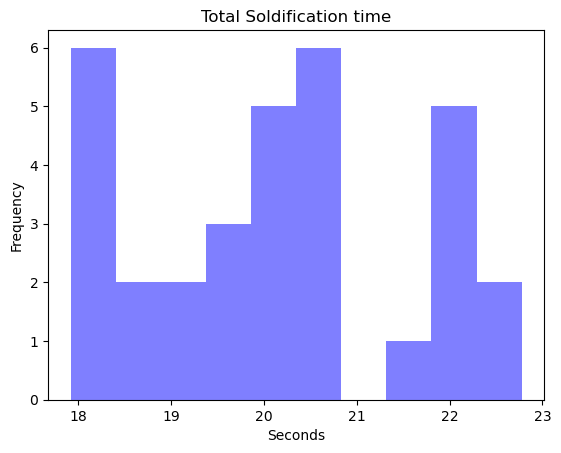

In [40]:
plt.hist(Res_doe_sol_time['total_sol_time'], bins=10, alpha=0.5, color='b')
plt.title('Total Soldification time')
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.show()

Regression model is developed

In [41]:


# Create the formula for the ANOVA
formula = 'total_sol_time ~ C(rho_l) + C(rho_s) + C(k_l) + C(k_s) + C(cp_l) + C(cp_s) + C(Surr_temp) + C(L_fusion) + C(temp_init)'

# Fit the model
model = sm.OLS.from_formula(formula, data=Res_doe_sol_time).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         total_sol_time   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1257.
Date:                Mon, 01 Jul 2024   Prob (F-statistic):           1.06e-27
Time:                        11:07:37   Log-Likelihood:                 42.888
No. Observations:                  32   AIC:                            -65.78
Df Residuals:                      22   BIC:                            -51.12
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [42]:
residuals_ols = model.resid
Res_doe_sol_time['Residuals'] =residuals_ols

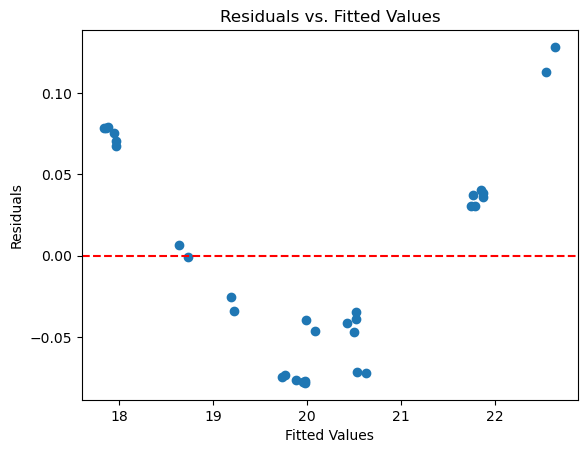

In [34]:
# Plot residuals vs. fitted values
plt.scatter(model.fittedvalues, residuals_ols)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

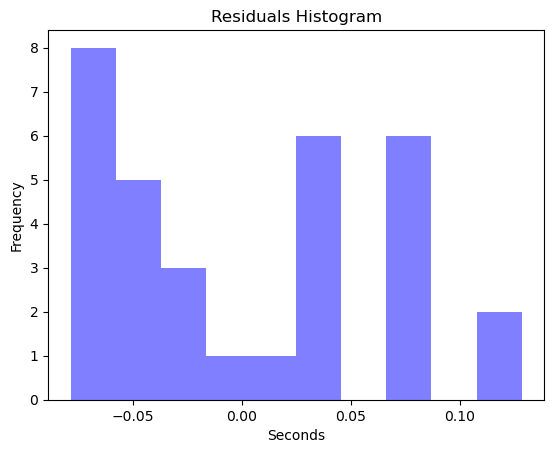

In [43]:
plt.hist(residuals_ols, bins=10, alpha=0.5, color='b')
plt.title('Residuals Histogram')
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.show()

Residuals of the model was calculated and the its normality is checked

In [44]:
from scipy.stats import shapiro

# Shapiro-Wilk Test
stat, p_value = shapiro(residuals_ols)
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p_value)

if p_value > 0.05:
    print('The residuals are normally distributed (fail to reject H0).')
else:
    print('The residuals are not normally distributed (reject H0).')


Shapiro-Wilk Test Statistic: 0.9076584806346442
p-value: 0.009757783776740997
The residuals are not normally distributed (reject H0).


Log transformation is performed on the response variable and then new model is developed

In [45]:
transformed_data = np.log( Res_doe_sol_time['total_sol_time']+ 1)  # Add 1 to avoid log(0)
Res_doe_sol_time['transf_data'] = transformed_data

# Create the formula for the ANOVA
formula2 = 'transf_data ~ C(rho_l) + C(rho_s) + C(k_l) + C(k_s) + C(cp_l) + C(cp_s) + C(Surr_temp) + C(L_fusion) + C(temp_init)'

# Fit the model
model2 = sm.OLS.from_formula(formula2, data=Res_doe_sol_time).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         total_sol_time   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1257.
Date:                Mon, 01 Jul 2024   Prob (F-statistic):           1.06e-27
Time:                        11:09:52   Log-Likelihood:                 42.888
No. Observations:                  32   AIC:                            -65.78
Df Residuals:                      22   BIC:                            -51.12
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

Residuals of the new model is calcualted and normality is performed on the new model

In [46]:
residuals2 = model2.resid

# Shapiro-Wilk Test
stat, p_value = shapiro(residuals2)
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p_value)

if p_value > 0.05:
    print('The residuals are normally distributed (fail to reject H0).')
else:
    print('The residuals are not normally distributed (reject H0).')

Shapiro-Wilk Test Statistic: 0.779605299848465
p-value: 1.725296086295955e-05
The residuals are not normally distributed (reject H0).


Generalised linear model is developed  for earlier model

In [48]:

# Create the formula for the ANOVA
formula = 'total_sol_time ~ C(rho_l) + C(rho_s) + C(k_l) + C(k_s) + C(cp_l) + C(cp_s) + C(Surr_temp) + C(L_fusion) + C(temp_init)'

# Fit the model
model3 = sm.GLS.from_formula(formula, data=Res_doe_sol_time).fit()
print(model3.summary())

                            GLS Regression Results                            
Dep. Variable:         total_sol_time   R-squared:                       0.998
Model:                            GLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1257.
Date:                Mon, 01 Jul 2024   Prob (F-statistic):           1.06e-27
Time:                        11:10:55   Log-Likelihood:                 42.888
No. Observations:                  32   AIC:                            -65.78
Df Residuals:                      22   BIC:                            -51.12
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [49]:
residuals3 = model3.resid

# Shapiro-Wilk Test
stat, p_value = shapiro(residuals3)
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p_value)

if p_value > 0.05:
    print('The residuals are normally distributed (fail to reject H0).')
else:
    print('The residuals are not normally distributed (reject H0).')

Shapiro-Wilk Test Statistic: 0.9076584806346442
p-value: 0.009757783776740997
The residuals are not normally distributed (reject H0).


Latin Hypercube Sampling is then explored.

In [55]:
n_factors = 9
n_levels = 2

# Create a Latin Hypercube Design

from pyDOE2 import lhs

design3 = lhs(n_factors, samples=100)
factor_levels = {
    'rho_l': [2760.0, 2761.0],
    'rho_s': [3000.0, 3001.0],
    'k_l': [96.0, 120.0],
    'k_s': [110.0, 130.0],
    'cp_l': [927.0, 947.0],
    'cp_s': [967.0, 987.0],
    'Surr_temp': [313.0, 323.0],
    'L_fusion': [389e3, 400e3 ],
    'temp_init': [880.0, 890.0],

}

factor_names = list(factor_levels.keys())
doe_lhs = pd.DataFrame(design3, columns=factor_names)

for i, (lower, upper) in enumerate(factor_levels.values()):
    doe_lhs.iloc[:, i] = lower + doe_lhs.iloc[:, i] * (upper - lower)



         rho_l        rho_s         k_l         k_s        cp_l        cp_s  \
0  2760.709812  3000.632795  116.937504  124.700792  933.297949  982.236346   
1  2760.956126  3000.919102  117.212050  113.775466  928.312524  979.471554   
2  2760.387227  3000.062142  116.256058  117.537194  942.240176  970.136492   
3  2760.180802  3000.493716  110.004456  125.116656  938.159158  979.270113   
4  2760.174834  3000.595042   98.726365  127.650600  945.586010  971.144929   

    Surr_temp       L_fusion   temp_init  
0  321.687306  391813.184525  889.859105  
1  314.241851  393602.934199  884.802075  
2  314.957540  399218.078635  888.718839  
3  321.373058  398249.706527  882.853447  
4  316.028035  399995.717591  883.172062  


In [65]:
Lhs_doe_sol_time = doe_lhs.copy()

Lhs_doe_sol_time['total_sol_time'] = [0.0] * Lhs_doe_sol_time.shape[0]

for i in range(Lhs_doe_sol_time.shape[0]):
    input_values = Lhs_doe_sol_time.iloc[i,:-1].values
    Lhs_doe_sol_time.at[i, 'total_sol_time'] = sim1d(*input_values)

print(Lhs_doe_sol_time.shape)

(100, 10)


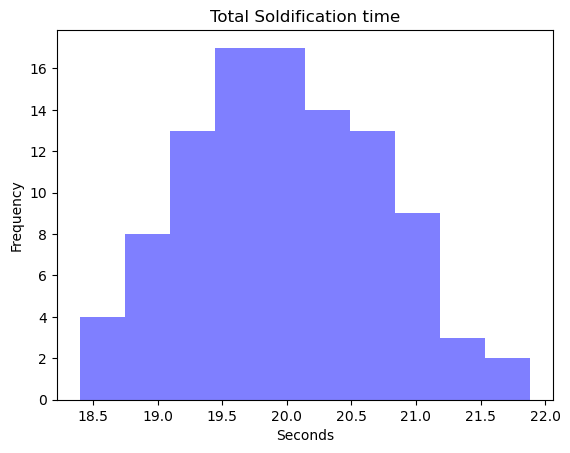

In [58]:
plt.hist(Lhs_doe_sol_time['total_sol_time'], bins=10, alpha=0.5, color='b')
plt.title('Total Soldification time')
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.show()

In [59]:
formula = 'total_sol_time ~ C(rho_l) + C(rho_s) + C(k_l) + C(k_s) + C(cp_l) + C(cp_s) + C(Surr_temp) + C(L_fusion) + C(temp_init)'

model_lhs = sm.OLS.from_formula(formula, data=Lhs_doe_sol_time).fit()
residual_lhs_ols = model_lhs.resid
Lhs_doe_sol_time['Residuals'] = residual_lhs_ols
print(model_lhs.summary())

                            OLS Regression Results                            
Dep. Variable:         total_sol_time   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 01 Jul 2024   Prob (F-statistic):                nan
Time:                        11:36:02   Log-Likelihood:                 3009.1
No. Observations:                 100   AIC:                            -5818.
Df Residuals:                       0   BIC:                            -5558.
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


Shapiro-Wilk Test Statistic: 0.6076612714334642
p-value: 6.031270507350353e-15
The residuals are not normally distributed (reject H0).


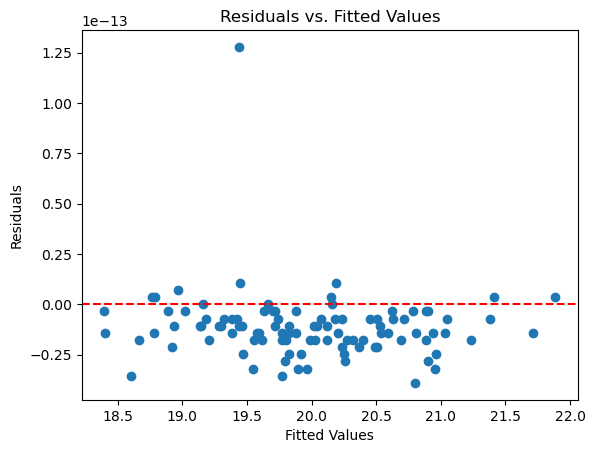

In [62]:
from scipy.stats import shapiro

# Shapiro-Wilk Test
stat, p_value = shapiro(residual_lhs_ols)
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p_value)

if p_value > 0.05:
    print('The residuals are normally distributed (fail to reject H0).')
else:
    print('The residuals are not normally distributed (reject H0).')


# Plot residuals vs. fitted values
plt.scatter(model_lhs.fittedvalues, residual_lhs_ols)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

The normality of the Residuals are still not satisfied so sobol sampling will be explored 

In [64]:
n_factors = 9
n_samples =100

# Create a Latin Hypercube Design

from pyDOE2 import sobol

sobol_sample = sobol(n_samples, n_factors)


factor_levels = {
    'rho_l': [2760.0, 2761.0],
    'rho_s': [3000.0, 3001.0],
    'k_l': [96.0, 120.0],
    'k_s': [110.0, 130.0],
    'cp_l': [927.0, 947.0],
    'cp_s': [967.0, 987.0],
    'Surr_temp': [313.0, 323.0],
    'L_fusion': [389e3, 400e3 ],
    'temp_init': [880.0, 890.0],

}

factor_names = list(factor_levels.keys())
doe_lhs = pd.DataFrame(design3, columns=factor_names)

for i, (lower, upper) in enumerate(factor_levels.values()):
    sobol_sample.iloc[:, i] = lower + sobol_sample.iloc[:, i] * (upper - lower)

print(sobol_sample.head(5))



ImportError: cannot import name 'sobol' from 'pyDOE2' (/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/pyDOE2/__init__.py)